Previous: [pipeline_vis](pipeline_vis.ipynb)  ::: Next [Synchronization](pipeline_synchronization.ipynb) 

# Schema `preprocess`

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)

Populating the interactive namespace from numpy and matplotlib


The `preprocess` schema extracts, aligns, and synchronizes multiphoton trace data from both galvo and AOD systems.

In [2]:
import datajoint as dj
from pipeline.preprocess import *

DataJoint 0.3.7 (July 31, 2016)
Loading local settings from dj_local_conf.json
Connecting dimitri@at-database.ad.bcm.edu:3306


Here are the main elements of the preprocess schema:

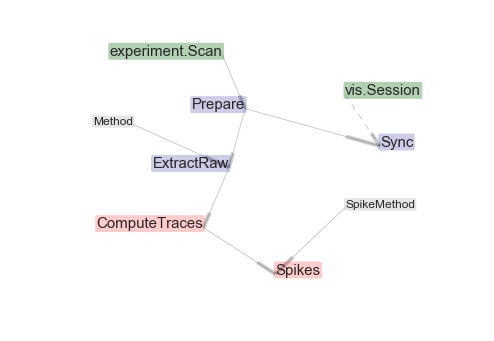

In [3]:
(dj.ERD.from_sequence([Prepare, Sync, ExtractRaw, Spikes])-1).draw()

`Prepare` and `ExtractRaw` combine the information from the galvo-based two-photon setups and the AOD-based setup. They perform all the operations that are specific to each type of imaging so that subsequent processing is no longer distinguished.

---

Many tables have *part tables*. A part table is so tightly dependent to its master table that it is never modified separately from its master.  They are implemented as nested classes.  Only one level of nesting is allowed.  In other words, parts cannot have their own parts.  On the ERD, parts are shown in a smaller font with no color code.

For example, `preprocess.Prepare` has many subtables that perform various jobs.

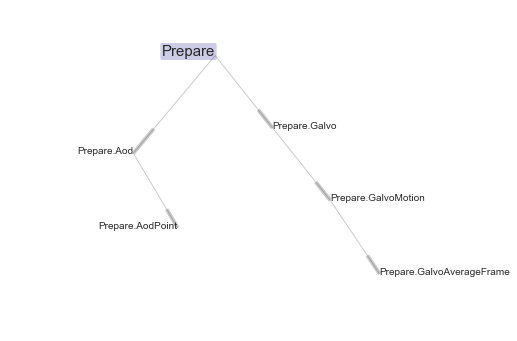

In [4]:
dj.ERD(Prepare).add_parts().draw()

Similarly, `preprocess.ExtractRaw` has several part tables.

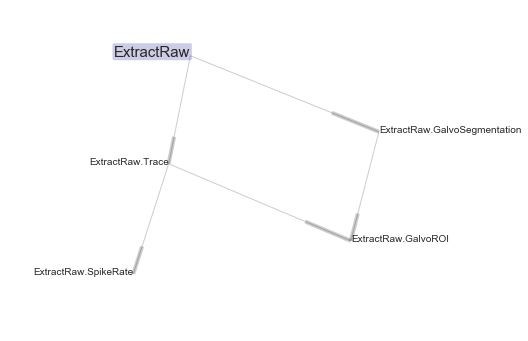

In [5]:
dj.ERD(ExtractRaw).add_parts().draw()

## Example: fetching and plotting average images of scans.
Many tables contain attributes of type `blob` or `longblob`, which contain array information such as images and traces:

In [6]:
Prepare.GalvoAverageFrame().heading

# average frame for each slice and channel after corrections
animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
slice                : tinyint                      # slice in scan
channel              : tinyint                      # 
---
frame                : longblob                     # average frame ater Anscombe, max-weighting,

---
If you know the exact identity of the scan of interest, use it as restriction:

In [7]:
frames = Prepare.GalvoAverageFrame() & dict(animal_id=8623, slice=3, scan_idx=6)
frames

animal_id,session,scan_idx,slice,channel,frame
8623,1,6,3,2,=BLOB=
8623,1,6,3,1,=BLOB=


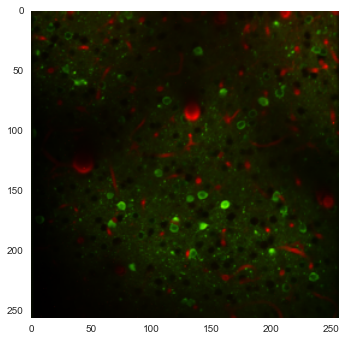

In [8]:
# fetch data
g, r = frames.fetch.order_by('channel')['frame']

# plot data
def normalize(img):
    m = img.min()
    return (img - m)/(img.max() - m)

plt.imshow(np.stack(
        [normalize(r), normalize(g), np.zeros_like(r)], 2))
grid(False)

---
Alternatively, get a whole set of scans matching some condition.

In [9]:
experiment.Fluorophore()

fluorophore,dye_description
GCaMP6f,
GCaMP6s,
mCherry,
mRuby,
OGB,
RCaMP1a,
tdTomato,


In [10]:
# select all slices imaged with GCaMP6f
slices = Prepare()*Slice() & (
    experiment.Session.Fluorophore() & 'fluorophore="GCaMP6f"') & Prepare.GalvoAverageFrame()
slices    

animal_id,session,scan_idx,slice
8487,1,5,1
8487,1,5,2
8487,1,5,3
8487,1,6,1
8487,1,6,2
8487,1,6,3
8487,1,7,1


---
To address each entity in the set, get its primary key values with the `fetch.keys()` iterator. Then each key can be used in a restriction.

In [11]:
keys = list(slices.fetch.keys())
key = keys[8]   #  pick an arbitrary frame
key

OrderedDict([('animal_id', 8487),
             ('session', 1),
             ('scan_idx', 7),
             ('slice', 3)])

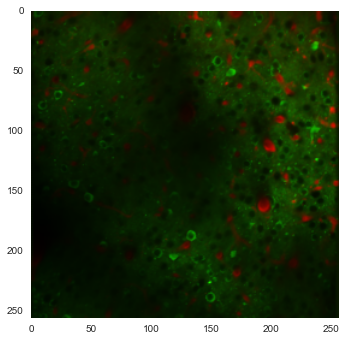

In [12]:
frames = Prepare.GalvoAverageFrame() & key  
g, r = frames.fetch.order_by('channel')['frame']
plt.imshow(np.stack(
        [normalize(r), normalize(g), np.zeros_like(r)], 2))
grid(False)

## Example: Plot calcium traces and inferred spikes

Raw calcium traces are hosted in `preprocess.ComputeTraces.Trace` whereas inferred spikes are hosted in `preprocess.Spikes.RateTrace`.

In [13]:
calcium = ComputeTraces.Trace()
spikes = Spikes.RateTrace()
traces = calcium*spikes  # combined raw and spike rate traces
traces.heading

animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
extract_method       : tinyint                      # 
trace_id             : smallint                     # 
spike_method         : smallint                     # spike inference method
---
trace=null           : longblob                     # leave null same as ExtractRaw.Trace
rate_trace=null      : longblob                     # leave null same as ExtractRaw.Trace

---
### Select the preprocessing method

In [14]:
Method.Galvo()   #  trace extraction methods for galvo imaging

extract_method,segmentation
1,manual
2,nmf


In [15]:
SpikeMethod()

spike_method,spike_method_name,spike_method_details,language
2,fastoopsi,nonnegative sparse deconvolution from Vogelstein (2010),matlab
3,stm,spike triggered mixture model from Theis et al. (2016),python
4,improved oopsi,,matlab
5,nmf,,matlab


In [16]:
traces &= dict(extract_method=2, spike_method=3)
traces

animal_id,session,scan_idx,extract_method,trace_id,spike_method,rate_trace,trace
8487,1,7,2,231,3,=BLOB=,=BLOB=
8487,1,10,2,130,3,=BLOB=,=BLOB=
8487,1,7,2,235,3,=BLOB=,=BLOB=
8487,1,10,2,134,3,=BLOB=,=BLOB=
8487,1,7,2,239,3,=BLOB=,=BLOB=
8487,1,10,2,138,3,=BLOB=,=BLOB=
8487,1,7,2,243,3,=BLOB=,=BLOB=


---
Let's plot a random trace:

In [17]:
key = np.random.choice(list(traces.fetch.keys()))   # pick a random trace
key

OrderedDict([('animal_id', 8628),
             ('session', 1),
             ('scan_idx', 3),
             ('extract_method', 2),
             ('trace_id', 104),
             ('spike_method', 3)])

In [18]:
# fetch synchronized times
times, nslices = (Sync()*Prepare.Galvo() & key).fetch1['frame_times', 'nslices']
times = times[0,::nslices] - times[0,0]  # start at 0

calcium, spikes = (traces & key).fetch1['trace', 'rate_trace']

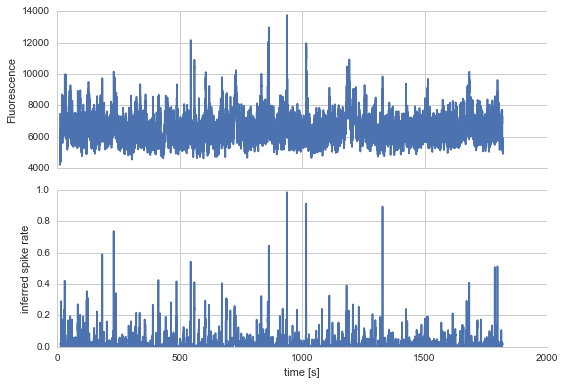

In [19]:
import seaborn as sns
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(times, calcium.squeeze(), label='Ca Trace')
ax[1].plot(times, spikes.squeeze(), label='Spike Rate')
ax[0].set_ylabel('Fluorescence')
ax[1].set_ylabel('inferred spike rate')
ax[1].set_xlabel('time [s]')
sns.despine(fig)
fig.tight_layout()

---
Next: [Synchronization](pipeline_synchronization.ipynb)